In [1]:
# 17232724 Assignment 2

# Output is given in binary format through a 1 deep array with all input columns as the channels.
# Hard to do without an image for input and cant use ImageDataGenerator with more than 4 channels.
# Ram intensive and inaccurate if using numpy for image generation with all inputs as separate channels in a 5/6 deep array with all inputs. 
# Only way I found to do Logistic Regression with CNN on a csv file was done below and producing a binary LR and not multinomial LR.


# all the required imports
import os
import keras
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from numpy import expand_dims

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.layers import Dense,  Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [2]:
#read data from zip file

#dataset = zipfile.ZipFile(os.getcwd() + '/DATA_08_11.zip')
dataset = zipfile.ZipFile(os.getcwd() + '/CSV.zip')
text_files = dataset.infolist()
results = []

#read in the players data
for line in text_files:
    #if line.filename.startswith("DATA_08_11/players"):
    if line.filename.startswith("CSV/players"):
        r = pd.read_csv(dataset.open(line.filename))
        results.append(r)

dataResults = pd.concat(results).drop(columns=['Unnamed: 0'])

In [3]:
dataResults[:15]

MapId  Win Rate  Loss Rate  Draw Rate
0   3.387153e+08     289.0      219.0      492.0
1   9.789749e+08     208.0       87.0      705.0
2   7.287586e+08     165.0      357.0      478.0
3   2.047251e+08     185.0      122.0      693.0
4   1.901295e+09       4.0       15.0      981.0
5   1.567030e+09     250.0      589.0      161.0
6   2.029429e+09     496.0      488.0       16.0
7   3.387828e+07       7.0       37.0      956.0
8   2.257697e+08      39.0       18.0      943.0
9   1.927023e+09     827.0      103.0       70.0
10  8.536037e+08     566.0      309.0      125.0
11  1.954918e+09     565.0      425.0       10.0
12  1.298640e+07     115.0       67.0      818.0
13  9.845531e+08     260.0      527.0      213.0
14  1.440797e+09     455.0      519.0       26.0

In [4]:
# Sum of the Win Rate of player 1 on every map
winRate = np.around(dataResults["Win Rate"].sum()/ (dataResults["Loss Rate"].sum() + dataResults["Draw Rate"].sum()),4)
print("The Win Rate Percentage is: " + str(winRate*100) + "%")

The Win Rate Percentage is: 69.89%


In [5]:
#split results of the maps line by line
currentMap = []
images = []
labels = []

# done with 1 deep array as Binary Logistic regression as mulitnomial LR with multiple channels results in ram intensive and awful outputs for accuracy etc.  
for line in text_files:
    #    if line.filename.startswith("DATA_08_11/map"):
    if line.filename.startswith("CSV/map"):
        splitdata = line.filename.split("map_", 1)
        filename = splitdata[1].split(".",1)
        id = int(filename[0])
        result = dataResults.loc[dataResults['MapId'] == id].values.astype(int)
        
        if result.size != 0:
            currentMap = pd.read_csv(dataset.open(line.filename),header=0).to_numpy().reshape(49, 49)
            images.append([currentMap])
            if (result[0][1]/(result[0][1]+result[0][2]+result[0][3]))>0.5:
              labels.append(1)
            else :
              labels.append(0)

In [6]:
#create numpty arrays for images and labels
images = np.array(images)
labels = np.array(labels)
print("labels: ",len(labels),"images: ", images.shape)
dataset.close()

labels:  8882 images:  (8882, 1, 49, 49)


In [7]:
#split data into train, test and validation and added a random state factor to shuffle data
imagesTrain, imagesValTest, labelsTrain, labelsValTest = train_test_split(images, labels, test_size=0.4, random_state=5)
imagesVal, imagesTest, labelsVal, labelsTest = train_test_split(imagesValTest, labelsValTest, test_size=0.5, random_state=7)
print(len(imagesTrain), len(imagesVal), len(imagesTest), len(labelsTrain), len(labelsVal), len(labelsTest))

5329 1776 1777 5329 1776 1777


In [8]:
imagesTrain.shape[1:]

(1, 49, 49)

In [9]:
#reshapes the data
shape, row,col= imagesTrain.shape[1:]

trainData = imagesTrain.reshape(imagesTrain.shape[0],row, col, shape)
testData = imagesTest.reshape(imagesTest.shape[0], row, col, shape)
valData = imagesVal.reshape(imagesVal.shape[0],row, col, shape)

input_shape = ( row, col, shape)
trainData = trainData.astype('float32')
testData = testData.astype('float32')
valData = valData.astype('float32')

In [10]:
# Training to generate image data while rotating the data for randomness  
train_datagen = ImageDataGenerator(rotation_range=0,horizontal_flip=True,vertical_flip=True,fill_mode="nearest")
val_datagen = ImageDataGenerator(rotation_range=0,horizontal_flip=True,vertical_flip=True,fill_mode="nearest")
test_datagen = ImageDataGenerator(rotation_range=0,horizontal_flip=True,vertical_flip=True,fill_mode="nearest")

train_datagen.fit(trainData)
val_datagen.fit(valData)
test_datagen.fit(testData)

In [11]:
#build model 
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',input_shape=input_shape, kernel_regularizer='l2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128 ,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [12]:
#as the dataset is messy, the results are also.
history = model.fit(train_datagen.flow(trainData, labelsTrain, batch_size=32), 
          steps_per_epoch=len(trainData)/32, epochs=15, verbose=1,
          validation_data=val_datagen.flow(valData, labelsVal, batch_size=32))

Epoch 1/15
167/166 [==============================] - 27s 159ms/step - loss: 0.6810 - accuracy: 0.6251 - val_loss: 0.6655 - val_accuracy: 0.6334
Epoch 2/15
167/166 [==============================] - 26s 156ms/step - loss: 0.6600 - accuracy: 0.6324 - val_loss: 0.6639 - val_accuracy: 0.6340
Epoch 3/15
167/166 [==============================] - 27s 164ms/step - loss: 0.6563 - accuracy: 0.6375 - val_loss: 0.6627 - val_accuracy: 0.6357
Epoch 4/15
167/166 [==============================] - 28s 167ms/step - loss: 0.6531 - accuracy: 0.6363 - val_loss: 0.6632 - val_accuracy: 0.6250
Epoch 5/15
167/166 [==============================] - 27s 161ms/step - loss: 0.6480 - accuracy: 0.6352 - val_loss: 0.6638 - val_accuracy: 0.6306
Epoch 6/15
167/166 [==============================] - 26s 154ms/step - loss: 0.6456 - accuracy: 0.6369 - val_loss: 0.6536 - val_accuracy: 0.6312
Epoch 7/15
167/166 [==============================] - 26s 155ms/step - loss: 0.6412 - accuracy: 0.6401 - val_loss: 0.6550 - val_ac

In [13]:
#evaluates the model using .flow
model.evaluate(test_datagen.flow(testData, labelsTest))

56/56 [==============================] - 2s 31ms/step - loss: 0.6552 - accuracy: 0.6348


[0.655194103717804, 0.6347777247428894]

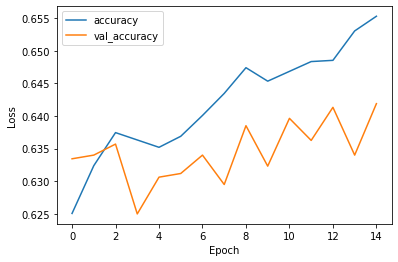

In [14]:
#plots graph for accuracy and val_accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

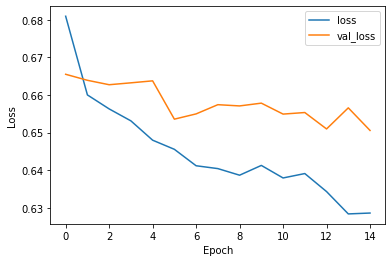

In [15]:
#plots graph for loss and val_loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')